## 2-1. 들어가며


### model.fit()에서 벗어나야 하는 이유

딥러닝 분야에서 모델링은 중요합니다. 하지만 그 모델을 잘 만든 후에 학습을 시키는 것도 중요합니다. 모델을 만들고 fit() 함수를 이용하여 쉽게 학습하는 것은 편하지만, 작은 것들 하나하나 컨트롤해보기 어렵고 문제가 생겼을 때 디버깅해보기 불편합니다. 저는 이전 version의 tensorflow와 제가 당시 사용하던 tensorflow가 가진 fit() 함수의 input 모양이 달라서 고생을 한 적이 있습니다. (하지만 100% fit()의 input 때문에 난 에러였는지 확실하진 않아요. 😅)

우리가 많은 것을 직접 컨트롤할 수 있다면 에러가 났을 때 디버깅이 편할 것임은 분명합니다. 그러므로 fit()을 사용하는 대신 직접 모델을 학습하는 트레이너를 만들어 모델을 학습시켜 봅시다!

### 학습 대상

이 노드는 model.fit()에서 벗어나고 싶은 사람, tfds.load(’mnist’)로 mnist 데이터 외에 새로운 데이터, 혹은 커스텀 데이터를 쓰는 튜토리얼을 읽고 싶은 사람, 커스텀 데이터를 model.fit()으로 학습하는 방법 말고 커스텀 트레이너로 학습하고 싶은 사람들을 위한 콘텐츠입니다.




### 데이터 경로 설정

콘텐츠 학습을 위한 데이터 경로 설정 코드입니다. 아래의 코드를 처음 한 번만 실행하셔도 됩니다.


In [1]:
! mkdir -p ~/aiffel/model-fit/data #디렉토리 생성
! cp -r ~/data ~/aiffel/model-fit/ #  data 디렉토리 링크 설정

### Directory Tree 구성하기
제가 처음 딥러닝을 하던 때에는 각종 멋진 딥러닝 프로젝트 Github들을 보면서 Directory Tree가 멋지다고 생각했습니다. Directory Tree는 너무나 알맞게 잘 구성되어 있었죠. 우리도 잠깐 우리의 작은 프로젝트가 어떨지 생각해보며, Directory Tree를 구성해보고 시작하는건 어떨까요?

```
/Users/eden/ByeModelFitFunc
├── DATASET
│   ├── TRAIN
│   ├── VAL
│   └── TEST
│
├── dataset.py		       # dataset loader
├── label.txt			    # dataset 클래스 이름이 있는 txt 파일
├── loss.py			      # loss function
├── main.py			      # model and data set, train
├── trainer.py			   # trainer
└── model.py			     # model
```

우리의 프로젝트는 위와 같이 구성될 것입니다. 늘어날지도 모르지만요. 늘어나려나? 모르겠어요.😂
참고로 프로젝트를 진행하기 위해서 tensorflow2와 캐글 데이터인 Yoga 데이터셋을 사용할 예정입니다.

위에서 보이는 Directory Tree에는 DATASET에 VAL, 즉 VALIDATION 셋이 보입니다. 하지만 아래와 같이 우리의 Yoga 데이터셋은 TRAIN, TEST 셋은 있지만 VALIDATION 셋은 없습니다.

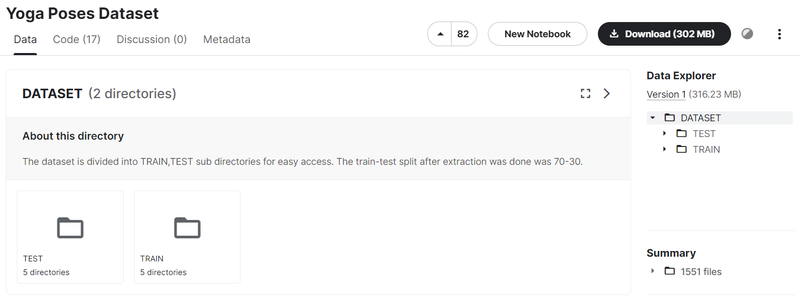

그래서 코드로 진입하기 전에! 한 번 8:2 정도로 TRAIN 셋을 쪼개보겠습니다.

In [3]:
import os
import random

data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
cls = [os.path.join(data_path, x) for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
cls

['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']

In [4]:
cls_files = {}

for x in cls:
    if x not in cls_files:
        cls_files[x] = [f for f in os.listdir(x) if os.path.isfile(os.path.join(x, f))]
        
cls_files

{'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess': ['00000164.jpg',
  '00000145.jpg',
  '00000097.jpg',
  '00000385.jpg',
  '00000250.jpg',
  '00000106.jpg',
  '00000105.jpg',
  '00000212.jpg',
  '00000360.jpg',
  '00000266.jpg',
  '00000209.jpg',
  '00000376.jpg',
  '00000107.jpg',
  '00000137.jpg',
  '00000363.jpg',
  '00000169.jpg',
  '00000126.JPG',
  '00000389.jpg',
  '00000111.jpg',
  '00000235.jpg',
  '00000278.png',
  '00000334.jpg',
  '00000197.jpg',
  '00000307.jpg',
  '00000190.jpg',
  '00000157.png',
  '00000206.jpg',
  '00000329.jpg',
  '00000320.jpg',
  '00000357.jpg',
  '00000228.jpg',
  '00000269.jpg',
  '00000395.jpg',
  '00000129.jpg',
  '00000272.png',
  '00000242.jpg',
  '00000149.jpg',
  '00000110.jpg',
  '00000276.jpg',
  '00000270.jpg',
  '00000282.png',
  '00000255.jpg',
  '00000123.png',
  '00000121.jpg',
  '00000150.jpg',
  '00000327.jpg',
  '00000136.jpg',
  '00000274.jpg',
  '00000345.jpg',
  '00000383.JPG',
  '00000127.png',
  '00000296.jpg',
  '000001

In [5]:
import random
import copy
import shutil

cls_val = {}
# 0.8, 0.2 비율로 기존의 TRAIN 셋을 나눠봅시다.
for x in cls:
    n_train_data = int(len(cls_files[x]) * 0.8) # train 비율 0.8
    n_val_data = len(cls_files[x]) - n_train_data # validation 비율 0.2
    print(len(cls_files[x]), n_train_data, n_val_data)
    train_data = random.sample(cls_files[x], n_train_data)
    val_data = copy.deepcopy(cls_files[x]) 
    
    for y in train_data: # TRAIN 폴더에서 VAL 폴더로 옮겨줄 데이터만 남기기
        val_data.remove(y)
        
    print(len(cls_files[x]), len(train_data), len(val_data))
    
    # 현재 클래스 디렉토리 생성
    x_cls = os.path.join('/aiffel/aiffel/model-fit/data/DATASET/VAL', x.split('/')[-1])
    os.makedirs(x_cls, exist_ok=True)
    for y in val_data:
        shutil.move(os.path.join(x, y), os.path.join(x_cls, y))
#         print(os.path.join(x, y), os.path.join(x_cls, y))

180 144 36
180 144 36


FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000106.jpg'

## 2-2. 데이터 로드하기

딥러닝 모델을 학습할 때는 무엇이 필요할까요?

데이터, 모델, loss 함수, optimizer 정도가 필요할 것 같아요. 우리는 모델을 학습하기 이전에 먼저 데이터를 가져와야 합니다. 이전에 Keras의 ImageDataGenerator를 사용하여 손쉽게 로드해왔으리라 생각됩니다. ImageDataGenerator는 원하는 배치 사이즈만큼 이미지를 아주 손쉽게 불러올 수 있고, 이미지 사이즈도 바꿀 수 있습니다. 하지만 우리는 잠시 ImageDataGenerator를 내려놓고 tf.data로 데이터를 가져오는 방법을 사용할 것입니다.

tf.data를 사용하면 좋은 점은 Tensorflow이 감당하기에 큰 사이즈의 데이터를 로드하기가 아주 좋으며, 재사용 가능한 조각들로 복잡한 입력 파이프라인을 구축할 수 있다는 것이라고 합니다. 제가 tf.data를 사용하게 된 이유는 큰 사이즈 데이터를 로드하기에 좋다는 것이었습니다.

그전에, 잠시 이 작은 프로젝트에서 사용할 데이터를 소개합니다. 우리는 Kaggle의 'Yoga Poses Dataset'을 사용할 예정입니다. 'Yoga Poses Dataset'에는 총 5개의 요가 동작과 그에 따른 이미지들이 있습니다. 저도 한 번도 사용해 본 적이 없는 데이터라서 과연 분류가 잘될지 궁금하네요 😁

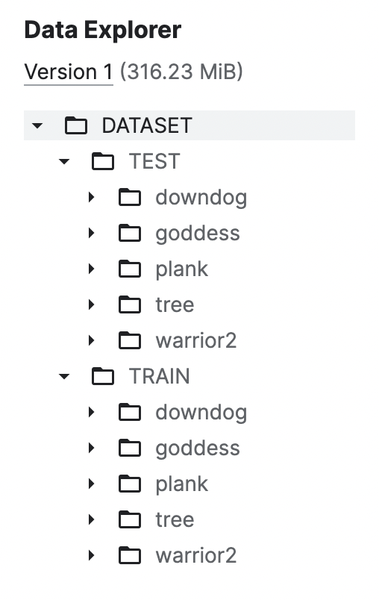

### 데이터 가져오기

자, 아래의 코드는 Directory Tree에서의 dataset.py의 일부입니다. tf.data를 이용해서 데이터를 가져오는 역할을 합니다.

데이터를 가져오기 위해 필요한 여러 가지 함수를 살펴봅시다.

가장 먼저 file_path로부터 class label을 만들고, 이미지를 읽는 함수를 만들어 볼까요?






In [6]:
!pip3 install tensorflow-estimator==2.6.0

In [8]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

그 다음은 TensorFlow Data API를 이용해 data batch를 만드는 함수입니다.






In [9]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

class 이름을 가져오는 함수도 만들어 봅시다.

In [11]:
def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)

데이터를 시각화해주는 함수도 만들어 보죠.

In [12]:
def show_batch(image_batch, label_batch, class_names):
    '''
    데이터를 시각화해주는 함수
    '''
    size = len(image_batch)
    sub_size = size
    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.rc('font', size=10)
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        print(plt.title(class_names[label_batch[n]==True][0].title()))
        plt.title(label_batch[n].numpy().decode('utf-8'))
        plt.imshow(image_batch[n])
    plt.show()

거의 다 왔습니다!

마지막으로 데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수를 만들면 됩니다.






In [13]:
def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

dataset.py에 작성되어 있는 코드로 만든 train_dataset 로더가 이미지와 라벨을 잘 가져오는지 확인해봅시다.






In [14]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN' 
train_dataset = load_data(data_path, batch_size=6)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

Find 5 class : ['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment
Improper call to JPEG library in state 203


InvalidArgumentError: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext]

와우! 역시 내 맘대로 한 번에 되는 법이 없지! 🤣

오류가 나네요.
이럴 땐 데이터가 문제가 있는지 코드에 문제가 있는지 확인을 해야합니다. 스크롤을 올려서 코드를 한 번 확인해 보세요.

흠.. 코드는 멀쩡한 것 같습니다. 데이터를 확인해보겠습니다.
뭔가 망가진 파일이 있을 것 같은 느낌적인 느낌느낌이 듭니다. Pillow의 verify로 한 번 체크해봅시다.

In [15]:
import glob
from PIL import Image

data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
extensions = ['.jpg', '.png', '.jpeg']

for i, img_path in enumerate(glob.glob(os.path.join(data_path, '*/*'))):
    try:
        img = Image.open(img_path)
        img.verify()
        print('Valid image')
    except Exception:
        print('Invalid image')

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

분명 문제가 있는데.. 아주 멀쩡하다는 듯이 모두 Valid image네요.
다른 방식으로 체크해보겠습니다. JPEG 이미지를 디코딩해서 오류가 나는 파일만 모으는 것입니다.
그 파일들은 삭제되어야하겠지요. 아래의 코드를 이용할 것입니다. [이곳](https://github.com/tensorflow/tensorflow/issues/7434#issuecomment-748435673)을 참고하였습니다.

In [16]:
from struct import unpack
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in glob.glob(os.path.join(data_path, '*/*')):
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)

print(bads)

['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree/00000181.jpg', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree/00000114.jpg']


다행히도 두 개의 파일이 걸렸습니다. (파일이 2개가 나오지 않는다면 기존의 데이터를 삭제하고 데이터를 다운로드한 후 처음부터 코드를 다시 실행시켜 주세요. 문제가 있는 파일이 1개 이하가 나온다면 학습할 때 오류가 날 수 있습니다. )
아래의 코드를 이용해 두 파일을 모두 지워주겠습니다.

In [18]:
for bad in bads:
    os.remove(bad)

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree/00000181.jpg'

에러가 나서 그냥 찾아서 지워줬다. 하나는 bmp였고 하나는 왜 그런지 모르겠음.


In [26]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
#     print(list_ds)
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment


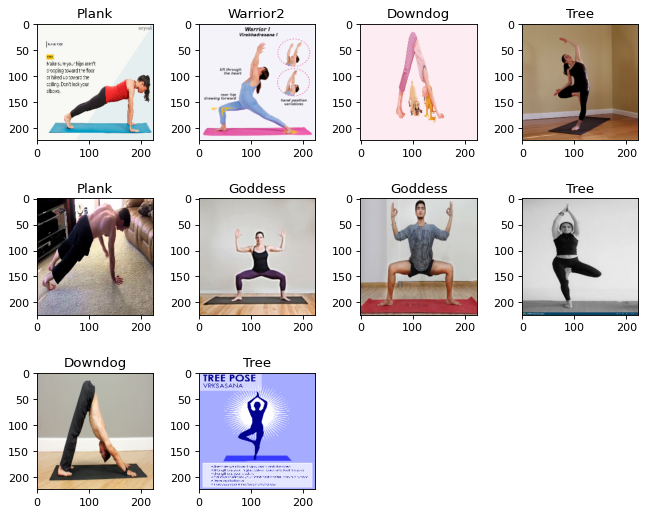

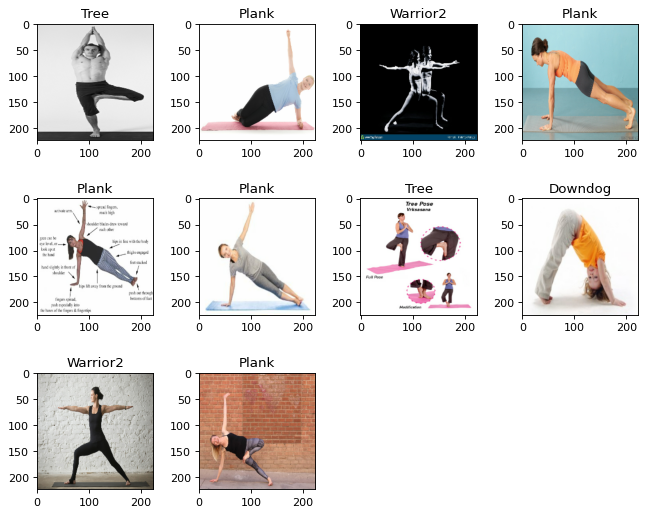

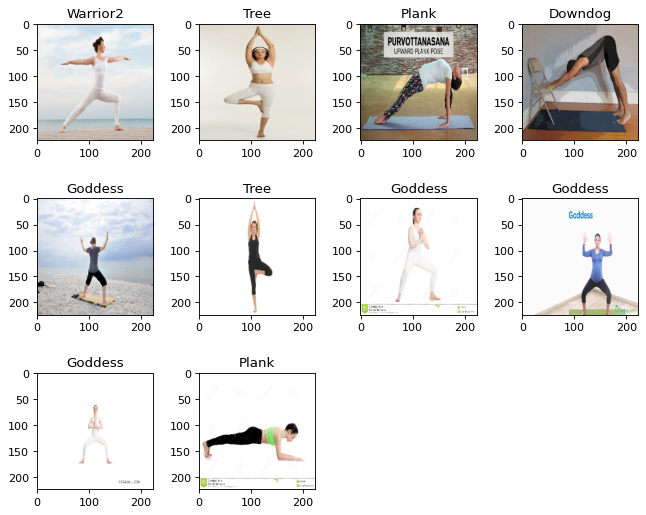

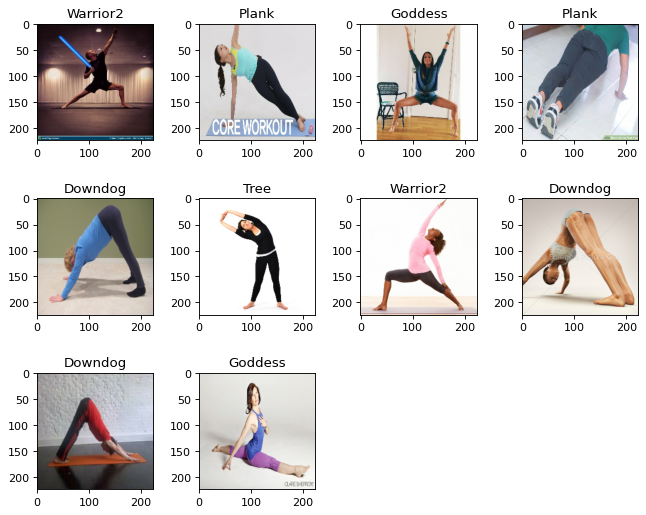

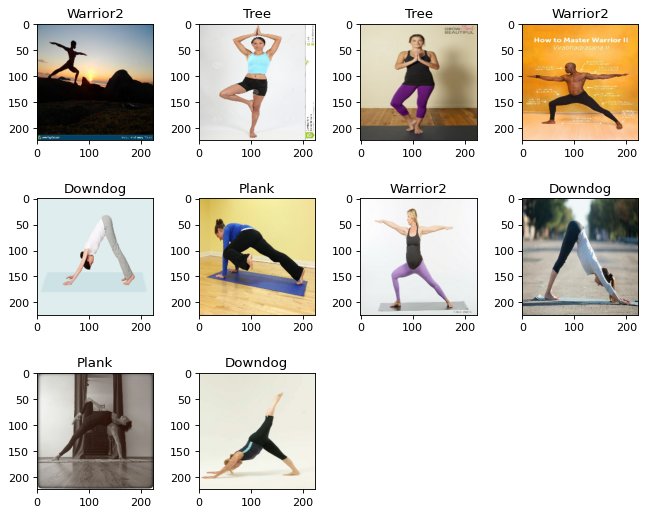

In [27]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
train_dataset = load_data(data_path, batch_size=10)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

## 코드 살펴보기
위의 코드에서 간단히 코드의 역할들을 몇 가지를 짚어보고 갑시다. 아래 설명 혹은 tensorflow docs를 참고해도 좋습니다.

### 1. tf.data.Dataset.list_files
출력 결과를 참고해보면 data_dir의 하위의 모든 파일들을 가져오는 역할을 한다는 것을 알 수 있습니다.

In [32]:
data_dir = '/aiffel/aiffel/model-fit/data/DATASET/TEST'
data_dir = pathlib.Path(data_path)

list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'))
for f in list_ds.take(5):
    print(f.numpy())
    img, label = process_path(f, "plank")
    print(label.)

b'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000210.jpg'
tf.Tensor(True, shape=(), dtype=bool)
b'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000199.jpg'
tf.Tensor(False, shape=(), dtype=bool)
b'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree/00000192.jpg'
tf.Tensor(False, shape=(), dtype=bool)
b'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree/00000077.jpg'
tf.Tensor(False, shape=(), dtype=bool)
b'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000132.jpg'
tf.Tensor(False, shape=(), dtype=bool)


### 2. list_ds.map(lambda x: process_path(x, class_names))
데이터셋에 변환(transformation)을 적용할 때 사용할 수 있습니다. 코드에서는 process_path라는 함수로 변환을 적용하게 만들었는데, 라벨과 이미지에 대한 변환을 적용했다는 것을 알 수 있습니다. resize 외에도 다양한 augmentation 코드를 추가해볼 수 있습니다!

In [33]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep) # file path parse해서 라벨 얻기 
    label = label[-2] == class_names # 라벨 인코딩

    img = tf.io.read_file(file_path) # 이미지 읽기
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 파일 디코딩
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지 타입 변환
    img = tf.image.resize(img, img_shape) # 이미지 사이즈 변환
    return img, label
    
labeled_ds = list_ds.map(lambda x: process_path(x, class_names))
labeled_ds

<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

### 3. cache(), shuffle(), repeat(), batch(), prefetch() 함수

아래의 설명이 어렵다면 [여기](https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset)를 참고하셔도 좋습니다. 이 글이 가장 설명을 잘했다고 생각합니다. 아래는 이 글을 번역하고 제 설명을 함께 추가한 것입니다.

1) ds.cache()
데이터셋을 메모리에 저장해 두고, 두 번째 이터레이션부터는 캐시된 데이터를 사용하여 시간을 아낄 수 있습니다. Epoch 동안 실행되는 일부 작업(예: 파일 열기 및 데이터 읽기)이 저장됩니다.

2) ds.shuffle(buffer_size=shuffle_buffer_size)
데이터셋을 섞어(shuffle) 줍니다. BUFFER_SIZE 만큼 임의로 샘플을 뽑고, 이 버퍼에서 랜덤하게 하나씩 나갈 때마다 원본 데이터 셋에서 아이템을 꺼내 다시 버퍼를 채웁니다. 완벽한 셔플링을 위해서는 데이터셋의 전체 크기보다 크거나 같은 버퍼 크기가 필요합니다.


예를 들어 내가 가진 데이터 셋이 [1, 2, 3, 4, 5, 6] 일 때 dataset.shuffle(buffer_size=3) 은 데이터 셋에서 버퍼 사이즈 3만큼 데이터를 랜덤하게 뽑습니다.

이렇게 생각하면 됩니다 :
```
랜덤 버퍼    
   |    
   |    다른 모든 데이터들이 있는 있는 원본 데이터 셋   
   |          |    
   ↓          ↓ 
[1,2,3] <= [4,5,6]
```
2가 랜덤 버퍼에서 나갔다고 생각해봅시다. 그럼 한 자리 빈 버퍼는 원본 데이터 셋에서 채워집니다. 그게 바로 4가 될 거예요:
```
2 <= [1,3,4] <= [5,6]
```
아무것도 남지 않을 때까지 계속 반복한다면 어떻게 될까요? 아래와 같이 될 것입니다.
```
1 <= [3,4,5] <= [6]
5 <= [3,4,6] <= []
3 <= [4,6]   <= []
6 <= [4]     <= []
4 <= []      <= []
```

나머지를 계속 볼까요?

3. ds.repeat()

데이터셋을 반복하여 생성합니다. repeat 함수에 arguments로 반복하고 싶은 수를 넣어주지 않으면 무한히 반복합니다. 따라서 코드가 멈춰야할 때를 결정해야 합니다.

4. ds.batch(batch_size)

batch 함수는 batch_size 만큼의 배치로 알아서 묶어줍니다. 주의할 점은 ds.repeat()는 ds.batch() 호출 이전에 있어야 한다는 점입니다. 그래야 생성된 데이터를 batch_size 만큼 묶어줄 수 있기 때문이죠.

5. ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

학습 중일 때, 데이터 로드 시간을 줄이기 위해 데이터를 미리 메모리에 적재시켜 둡니다. 즉, 모델이 step s를 실행하는 동안 입력 파이프라인은 step s+1의 데이터를 미리 읽습니다. 대부분의 dataset input 파이프라인은 prefetch 호출로 끝나야 합니다. prefetch(n)이라고 한다면 n 배치 만큼을 모델이 학습하는 동안 동시에 메모리에 적재시키게 됩니다. 데이터 로드 시간이 줄면 전체 학습 시간이 줄어드는 효과가 있습니다.

In [34]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, n_repeat=3):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(n_repeat)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

## 2-3. 모델 만들기

자, 이제 데이터를 가져오도록 파이프라인을 만들었으니, 모델을 구성해보도록 합시다.

### EfficientNet 간단히 알아보기

우리가 사용할 EfficientNet은 2019년 ICML에서 나온 논문인 [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)에서 제안하는 모델입니다.

2019년 당시에는 아래 그림처럼 neural network의 depth를 더 깊게, channel 개수를 더 많이, input image size를 더 크게 만드는 방식의 딥러닝 모델이 많이 제안되었습니다. 하지만 한정된 자원으로는 사이즈가 거대한 만든 모델을 마냥 학습시키기는 어렵기 때문에, 이 논문에서는 AutoML을 이용하여 depth, channel, resolution(input image size)의 최적의 조합을 찾아내려고 하였습니다.

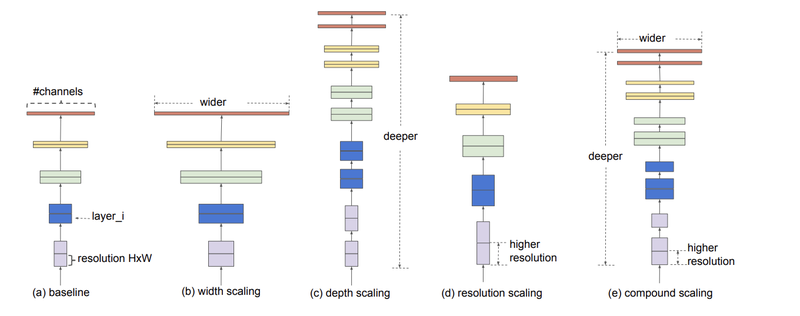

아래 그래프에서 보이는 것과 같이 EfficientNet은 우리가 사용할 B0부터 B7이 있으며, 0에서 7로 갈수록 파라미터 갯수도 많아지고 image resolution도 커집니다. 결과적으로 더 적은 파라미터로 더 높은 정확도를 갖는 모델이 제안되었습니다.

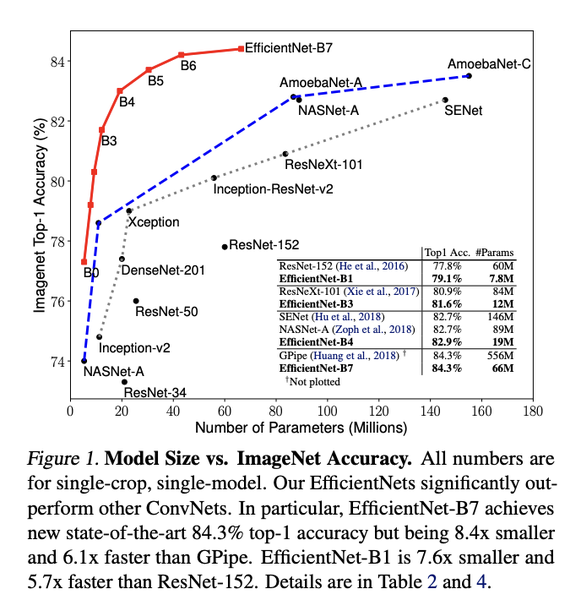

모델에 대한 내용 설명은 여기까지 하겠습니다. 여기서 중요한 것은 개별 모델을 알아보는 것이 아니라 'model.fit()에서 벗어나는 방법'이니까요. 😆 EfficientNet에 대해 더 알고 싶은 분들은 [논문](https://arxiv.org/pdf/1905.11946.pdf)을 꼼꼼히 읽어보기를 추천드립니다.

### EfficientNetB0 사용하기

언뜻 보기에도 너무도 좋아보이는 EfficientNet을 백본으로 사용하기 위해 우리는 굳이 개발할 필요가 없습니다.
[케라스가 제공하는 EfficientNet](https://keras.io/api/applications/efficientnet/)을 가져와서 사용할 것입니다! 편-안 😎

어떤 간단한 모델을 돌려볼 때는 자원이 충분하면 모르겠지만 그런 상황이 아니라면 적당한 사이즈의 작은 모델을 먼저 돌려보는 것을 추천합니다. 위에서 이미 확인한 바와 같이 EfficientNetB0도 이미 꽤나 파워풀하니 우리는 B0를 사용해보겠습니다.

In [35]:
from tensorflow.keras.applications import EfficientNetB0

class YogaPose(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=5, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = YogaPose(num_classes=5, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

16719872/16705208 [==============================] - 0s 0us/step
Model: "yoga_pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  6405      
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
_________________________________________________________________
None


```
Model: "yoga_pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  6405      
=================================================================
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
_________________________________________________________________
None
```

위와 같이 model.py에 YogaPose라는 이름을 가진 모델을 이렇게 만들었습니다.
여기서 하나 유의할 점은 base model인 EfficientNetB0의 weights를 freeze 시켜서 top 부분만을 학습할 것인지, EfficientNetB0를 전부 학습시킬 것인지 결정해야 된다는 것입니다.

## 2-4. 트레이너 만들기

우리는 이제 데이터도 있고 모델도 가지고 있습니다. 이제 학습만 하면 됩니다.
[Tensorflow docs](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=ko)를 참고하여 트레이너를 만들어봅시다.

In [36]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

loss function, optimizer를 모두 train()의 매개변수로 넣어주었지만 생성자에 같이 넣는 게 더 좋을지도 모르겠습니다. 코드를 잠깐 뜯어봅시다.

train() 함수는 아래 코드와 같이 시작합니다.

```
for epoch in range(self.epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
```

왜죠?

원하는 epoch만큼 학습을 해야하기 때문입니다. 매 epoch마다 print문을 찍어뒀습니다. 그리고 매 배치를 가져올 때마다 with tf.GradientTape() as tape라는 것 안에 들어갑니다.

이건 뭘까요? 테이프..? 웬 📼...?

딥러닝을 학습한다는 것은 모델이 loss 혹은 cost를 최소화시키도록 만든다는 것이라고 할 수 있습니다. 이 과정에서 backpropagation을 합니다. 초심으로 돌아가서 다시 본다면 아래 이미지가 설명하는 것이 backpropagation입니다.

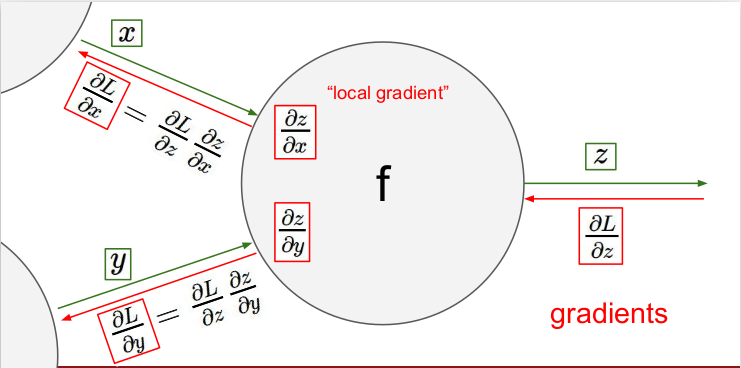

Tensorflow docs에서 이렇게 설명해줍니다.

> tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록" 합니다. 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 “기록된” 연산의 그래디언트를 계산합니다.

말로만 설명하면 어렵기 때문에 예시를 하나 가져왔습니다.


x가 3.0이라는 스칼라 값을 가지고 있는 변수이고 y=x^2이라는 함수라고 할 때 GradientTape.gradient(target, sources)를 사용하여 그라디언트를 구한다고 한다면 아래와 같은 값을 얻을 수 있습니다.

In [37]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2
  
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()
# 출력 결과
# 6.0

6.0

위와 같은 이유 때문에 우리는 tf.GradientTape를 사용합니다.

모델이 예측한 값은 logit이 됩니다. 그리고 로스(loss) 함수로부터 true label과 모델이 예측한 logits 사이의 loss를 구할 수 있겠습니다. 후에 tape.gradient()로 그라디언트를 계산하고 optimizer에 적용시켜줍니다. 마지막으로 train metric.update_state는 각 배치마다 모델을 평가하는 metric에 알맞은 값을 업데이트해줍니다.

이 과정을 코드로 표현하면 아래와 같습니다.

```
with tf.GradientTape() as tape:
    logits = model(x_batch_train, training=True)   # 모델이 예측한 값
    loss_value = self.loss_fn(y_batch_train, logits)   # loss 구하기 
    # tf.print(loss_value)
grads = tape.gradient(loss_value, model.trainable_weights)
self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
# Update training metric.
train_metric.update_state(y_batch_train, logits)
```

이제 학습이 되는지 확인해볼까요!

loss function, optimizer는 물론 커스텀으로도 가능하지만 이번엔 그냥 있는 걸 가져다 쓰려고 합니다. 아마도 귀찮아서 그런 것이 아니라...🤭

저는 5 배치마다 train_metric.result()를 출력하도록 하였습니다.
학습은 5분 정도 걸릴 수 있어요. 돌려 놓고 스트레칭 또는 요가를 해보시는 건 어떨까요? 🤸🧘 (혹시라도 학습 시간이 10분 이상, step이 1000 이상이라면 코드 쉘 왼쪽 상단의 검은 사각형을 눌러 과감히 학습를 중지시켜 주세요. 다음 스텝에서도 학습은 이루어지까요.🥲 )

In [38]:
epoch = 1
batch = 5
model = YogaPose(num_classes=5)
dataset = load_data(data_path=data_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer)

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)


Start of epoch 0


Corrupt JPEG data: premature end of data segment


Training loss (for one batch) at step 0: 4.4508
Seen so far: 5 samples
0.0
Training loss (for one batch) at step 5: 1.3235
Seen so far: 30 samples
0.23333333
Training loss (for one batch) at step 10: 1.4065
Seen so far: 55 samples
0.29090908
Training loss (for one batch) at step 15: 2.3239
Seen so far: 80 samples
0.3625
Training loss (for one batch) at step 20: 3.3349
Seen so far: 105 samples
0.37142858
Training loss (for one batch) at step 25: 0.6149
Seen so far: 130 samples
0.4076923
Training loss (for one batch) at step 30: 0.2335
Seen so far: 155 samples
0.44516128
Training loss (for one batch) at step 35: 1.5775
Seen so far: 180 samples
0.45555556
Training loss (for one batch) at step 40: 0.3490
Seen so far: 205 samples
0.47317073
Training loss (for one batch) at step 45: 2.1821
Seen so far: 230 samples
0.4869565
Training loss (for one batch) at step 50: 0.0926
Seen so far: 255 samples
0.48235294
Training loss (for one batch) at step 55: 0.4104
Seen so far: 280 samples
0.4857143
T

Training loss (for one batch) at step 480: 0.2971
Seen so far: 2405 samples
0.68024945
Training loss (for one batch) at step 485: 0.0442
Seen so far: 2430 samples
0.6823045
Training loss (for one batch) at step 490: 0.0268
Seen so far: 2455 samples
0.6830957
Training loss (for one batch) at step 495: 0.0076
Seen so far: 2480 samples
0.6846774
Training loss (for one batch) at step 500: 3.3465
Seen so far: 2505 samples
0.6858283
Training loss (for one batch) at step 505: 1.3856
Seen so far: 2530 samples
0.68774706
Training loss (for one batch) at step 510: 1.3124
Seen so far: 2555 samples
0.68845403
Training loss (for one batch) at step 515: 3.4083
Seen so far: 2580 samples
0.6895349
Training acc over epoch: 0.6899


학습은 끝났습니다. 그러나 학습만 한다고 끝은 아니겠죠? 모델을 저장해야 되고, 데이터가 작을 땐 몰라도 크면 얼마나 배치가 돌아가고 있는지 궁금합니다. 그렇기 때문에 ProgBar도 있으면 좋겠습니다.

하지만 모델을 저장할 때 모든 모델을 저장하는 것은 이미 로컬에 이 데이터, 저 데이터 모두 저장해둬서 고통받고 있는 컴퓨터에게 무리한 요구일 수 있습니다. 따라서 가장 좋은 모델을 저장하는 것도 괜찮은 방법일 것 같습니다.

지금까지는 tf.data를 사용하여 데이터를 로드하고, 트레이너를 만들어 단순히 학습하는 것까지 진행해보았습니다. 바로 위에서 이야기한 모든 기능들은 다음 스텝에서 진행해보겠습니다. 그 후 모델을 저장하고 요가 자세 모델이 얼마나 완벽한지 테스트해봅시다.

## 2-5. Progbar, Validation 데이터 추가하기

지금까지 우리는 아래 세 가지를 진행해보았습니다.

- tf.data를 이용한 데이터 로드하기
- tf.keras.Model을 상속받아 나만의 모델 만들기
- Train loop로 모델 학습하기

하지만 우리가 만들었던 간단한 train loop로는 지금 어느 정도 학습되고 있는지, loss가 어느 정도 인지를 알 수 없었고, 모델을 저장하지도 못했습니다. 하지만 나중에 학습한 모델을 가져다 쓰기 위해 모델 저장은 필수죠!

이제부턴 그것들을 해보려고 합니다! 추가로 argparse를 이용하여 epoch, batch 사이즈 등의 값을 읽어오도록 해보겠습니다. 불태워봅시다. 🔥


⚠️ WARNING
주의할 사항은 이전에 만든 코드에 여러가지를 덧붙여서 수정하는 것이므로 조각 코드가 주로 나올 예정입니다.
이전 코드의 어느 부분이 바뀌고 있는지 생각하면서 읽어가는 것이 좋습니다.

### Train loop에 기능 추가하기

#### 1. Progbar 추가하기
Progbar란 Progression Bar의 줄임말로, 학습이 얼마나 진행되었는지 아래 그림과 같은 바 형태로 보여주는 것입니다.

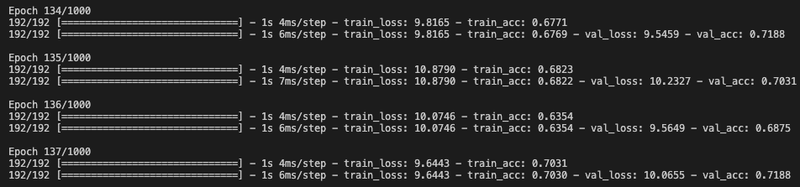

이전 Trainer의 train() 함수는 train_dataset, train_metric 단 두 개만을 인자로 받았습니다. 그러나 이제는 각 step 별로 Progbar를 찍어주기 위해 steps_per_epoch라는 인자를 추가해줄 것입니다.

여기서 step이란 batch 1개의 loss를 계산하고 gradient를 한 번 업데이트하는 것을 말합니다. 그 step은 어떻게 구할 수 있을까요?
전체 학습 데이터 사이즈를 TRAIN_SIZE라고 했을 때, 그걸 batch 사이즈로 나눈 것이 step 수가 되겠죠?


코드로 바꾼다면 아래의 lambda 함수로 compute_steps_per_epoch을 계산할 수 있을 것입니다
```
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
```
위 코드에서 우리가 아직 구해놓지 않은 값이 있습니다. 바로 TRAIN_SIZE 입니다.
그래서 기존의 load_data에서 데이터를 가져올 때 TRAIN_SIZE를 함께 계산하여 가져오게 할 것입니다. 바로 이렇게 말이죠!

```
train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
```

그러기 위해선 load_data 함수내에서 TRAIN_SIZE를 계산하도록 하여야합니다. 아래의 load_data 함수가 우리의 새로운 함수입니다. tf.data.experimental.cardinality(list_ds).numpy()을 이용해 DATASET_SIZE를 계산해서 반환해주고, img_shape를 함수의 파라미터로 넣어서 EfficientB0 말고도 다른 input image resolution을 갖는 모델들을 사용할 수 있게 바꿔주었습니다.

In [39]:
def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

이제 step 사이즈도 알았으니 step마다 진행 사항을 찍어줄 수 있을 것 같습니다!

방금 전 step은 batch 1개의 loss를 계산하고 gradient를 한 번 업데이트하는 것이라고 말했습니다. 그렇다면 우리가 업데이트시켜야 할 코드는 Trainer 부분이 될 것입니다.

진행 사항을 찍기 위해 from tensorflow.keras.utils import Progbar를 사용해보겠습니다.

우리가 원하는 Progbar의 전체 길이는 steps_per_epoch(이전에 구한 DATA_SIZE) x batch가 될 것입니다. 1 step마다 1 batch를 사용하게 되니까요.
휴, 헷갈리죠? 😵 Progbar는 아래처럼 만들면 됩니다.

```
metrics_names = ['train_loss']
progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)
```

매 step이 바뀔 때마다 update 함수를 사용해주면 됩니다. values에는 progbar에서 보여주고 싶은 값을 넣어주면 됩니다.

```
values = [('train_loss', train_loss), ('train_acc', train_acc)]
progBar.update((step_train + 1) * self.batch, values=values)
```
> 참고: Progbar 외에도 tqdm, 커스텀 progress bar 등 어떤 것으로 만들어도 상관없습니다.

#### 2. Validation 데이터 추가하기
우리는 지금까지 train 데이터로만 진행을 해왔습니다. 하지만 운좋게도 validation 데이터가 있는 상황도 있을 것입니다. validation 데이터 추가를 했다고 해서 크게 코드에 차이가 있지 않습니다. 그래서 빠르게 validation 데이터를 추가해보도록 하겠습니다.

저는 validation 데이터가 따로 있다고 가정하고 만들었습니다.
그렇다는 건 train_path, val_path가 모두 존재한다는 뜻이겠죠! 단순히 load_data를 두 번 해주는 것에 지나치지 않습니다. 코드는 아래와 같습니다.

```
train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)
```

하지만 이 데이터를 train step에 넣어주려면 어떻게 해야 될까요? 당연히 Trainer 클래스의 train 함수에 arguments를 늘려줘야겠죠. validation을 위한 Progbar 역시 만들어주도록 해봅시다.

오! 슬슬 복잡해지는 것처럼 보입니다. 그럴 땐 튜토리얼을 읽지 않고 github 클론이나 받아서 코드나 돌려볼까 하는 마음이 생기죠. 😣
```
for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
    logits = model(x_batch_val, training=False)
    val_loss = self.loss_fn(y_batch_val, logits)
    
    # Update val metrics
    val_acc = self.compute_acc(logits, y_batch_val)
    values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]

progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
```

이제 dataset.py, model.py를 전부 가져와서 위의 코드가 잘 동작하는지 해봅시다!

In [40]:
'''
dataset.py의 코드입니다! 
'''
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()

def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    print(class_names)
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [41]:
import math

train_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
val_path = '/aiffel/aiffel/model-fit/data/DATASET/VAL'
batch_size = 32

train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

['goddess', 'plank', 'downdog', 'tree', 'warrior2']
['goddess', 'plank', 'downdog', 'tree', 'warrior2']


바뀐 Trainer 클래스를 확인하기 전에 기존의 Trainer와 비교하여 train 부분은 train_on_batch 함수로 그대로 빼뒀습니다.
train_on_batch 함수로 빼놓으면서 위에 @tf.function 데코레이터가 붙었습니다. 이 부분을 잠시 얘기하고 가겠습니다.

머나먼 옛날은 아니지만 몇 년 전 TensorFlow v1을 주로 사용하던 시절이 있습니다.

TensorFlow라는 이름에서 알 수 있듯 Tensor들이 data flow graph(이하 graph)를 Flow한다고 생각하면 되는데 여기서 그렇다면 graph는 무엇일까요?

우리가 만드는 Convolutional layer도, RNN계열의 LSTM도 결국 어떤 연산입니다. 그래서 graph는 모델이 학습되는 전체 연산을 아래 gif 처럼 노드(연산)와 방향(엣지)로 나타낸 것이라고 할 수 있습니다.

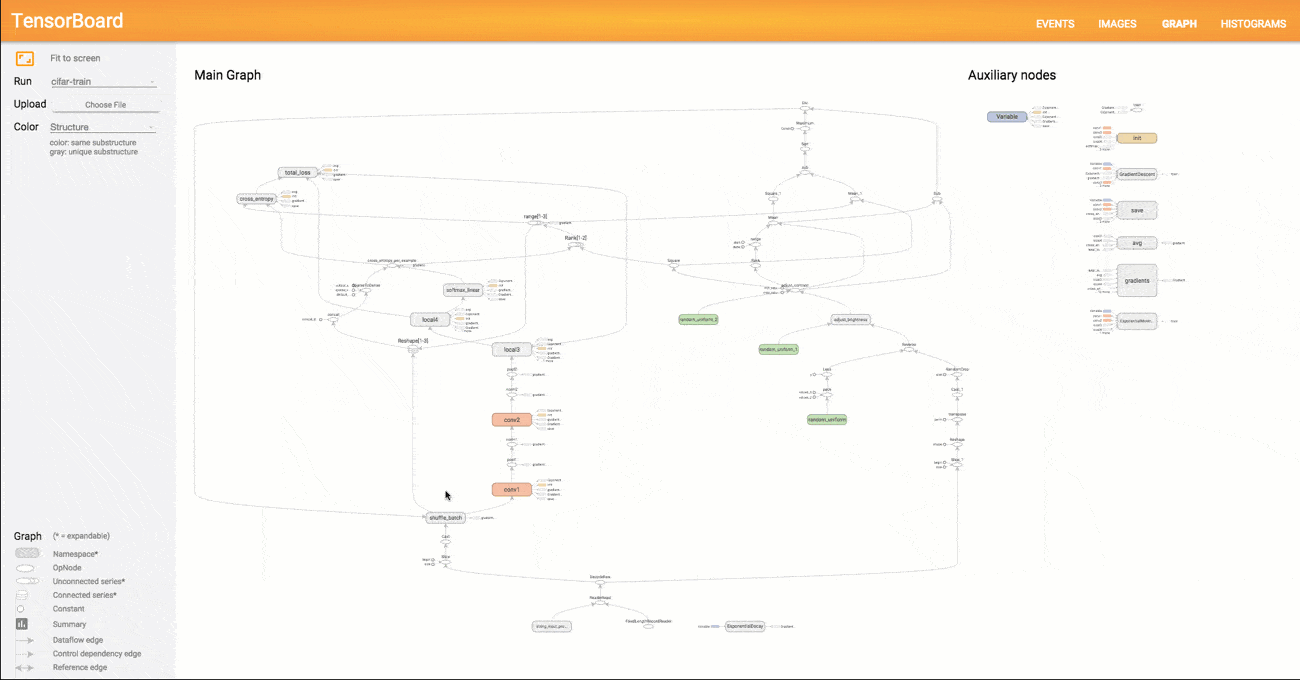

다시 원점으로 돌아가서 TensorFlow v1에서는 graph를 생성하고 이후에 연산을 실행하는 과정을 분리했었습니다. 그에 대해 약간의 불편함을 느끼는 유저들이 많았기 때문에 TensorFlow v2에서 Session이 사라지고 바로 연산을 실행할 수 있는 Eager Execution이 생겼습니다.

하지만 v1에서 graph와 연산 실행을 나눠놓은 이유는 더 빠른 속도로 연산을 할 수 있기 때문이었습니다. 따라서 TensorFlow v2에서 v1과 같이 그래프 생성, 연산 실행을 분리하여 속도를 더 빠르게 하고싶을 때는 @tf.fucnction 데코레이터를 붙이면 됩니다.

In [42]:
from tensorflow.keras.utils import Progbar

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [44]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/3
27/27 [==============================] - 18s 386ms/step - train_loss: 1.9702 - train_acc: 0.4375 - val_loss: 1.6164 - val_acc: 0.1562

Epoch 2/3
27/27 [==============================] - 12s 374ms/step - train_loss: 1.7221 - train_acc: 0.5938 - val_loss: 1.6004 - val_acc: 0.3125

Epoch 3/3
27/27 [==============================] - 12s 368ms/step - train_loss: 1.6212 - train_acc: 0.6562 - val_loss: 1.6262 - val_acc: 0.1562


음~ acc가 잘 나오는진 모르겠지만 스무스하게 잘 학습됩니다.

안타깝게도 우리는 우리가 학습한 모델을 쓸 수 없습니다. 저장을 하지 않았기 때문입니다.

이제 모델을 저장해보겠습니다.

#### 3. 모델 저장하기

이제 학습과 관련하여 몇 가지 처리를 해놓았으니, 학습된 모델을 저장해보도록 합시다. 기쁘게도 tensorflow에는 tf.train.Checkpoint라는 것이 있습니다. 모델을 저장해주는 아주 친절한 친구입니다.

사용법은 아주 간단합니다. 쓰려고 미리 준비해뒀던 optimizer와 model을 인자로 넣어주고 checkpoint를 만든 뒤, 그 checkpoint를 checkpoint manager로 만들면 됩니다. 이때 directory에는 모델이 저장될 directory를 입력하고, max_to_keep에는 최대로 저장할 모델의 개수를 지정해줍니다.

```
model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory=".", max_to_keep=5)
```

그다음엔 역시 Trainer 클래스의 train 함수에 manager를(tf.train.CheckpointManager 객체) 보내 1 epoch이 끝날 때마다 manager.save()를 넣어 모델을 저장해주면 됩니다. 하지만 tensorflow와 keras에는 callback이라는 것이 있죠. 그 callback 중엔 학습한 모델 중 가장 좋은 모델만 저장해주는 애가 있습니다. 우리도 그것과 비스무리한 걸 구현해볼까 합니다.

가장 좋은 모델을 저장하려면 임의의 loss인 best_loss를 두고, 매번 생기는 val_loss가 그것보다 낮을 때만 모델을 저장하게 하면 됩니다. loss는 0에 가까워질수록 좋으니까요.

loss가 아닌 acc로 해도 무방합니다. 단 best_loss가 아닌 best_acc일 경우에는 이전의 acc보다 현재 acc가 더 높을 때 저장을 해야한다는 것을 주의해야합니다.

In [46]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step, checkpoint_manager):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        best_loss = 100
        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
            
            if val_loss < best_loss:
                best_loss = val_loss
                print("\nSave better model")
                print(checkpoint_manager.save())

In [47]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory="aiffel/model-fit/checkpoint", max_to_keep=5) #체크포인트 저장위치 자유롭게 변경

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric,
            checkpoint_manager=manager)


Epoch 1/3
27/27 [==============================] - 18s 396ms/step - train_loss: 2.0718 - train_acc: 0.3438 - val_loss: 1.8478 - val_acc: 0.0938

Save better model
aiffel/model-fit/checkpoint/ckpt-1

Epoch 2/3
27/27 [==============================] - 12s 397ms/step - train_loss: 1.4952 - train_acc: 0.6875 - val_loss: 1.8806 - val_acc: 0.1562

Epoch 3/3
27/27 [==============================] - 13s 400ms/step - train_loss: 1.4390 - train_acc: 0.7812 - val_loss: 1.8378 - val_acc: 0.1250

Save better model
aiffel/model-fit/checkpoint/ckpt-2


## 2-6. Coarse label로 custom dataloader 만들어보기


우리는 지금 CNN 모델을 이용해 어떤 요가 포즈 classification 모델을 만들려고 합니다. 그리고 그 모델을 fit() 함수가 아닌 trainer를 이용하여 학습하는 것이 궁극적인 목표죠. 하지만 예제 코드를 만들면서 저는 제가 만든 모델에 문제가 생겼다는 것을 깨달았습니다. 모범이 되어야 할 것만 같은 예시 딥러닝 모델의 정확도가 너무 낮다는 것이었습니다. 그래서 저는 모델에게 이미지뿐만 아니라 더 많은 정보를 주기로 했습니다. 바로 딥러닝 모델에 Yogapose(요가를 하는 사람 이미지) 이미지와 해당 이미지에 있는 요가 중인 사람의 keypoints 정보까지 넣어주는 것이죠!

지금까지 사용한 데이터는 왼쪽의 내 요가 이미지이고, 이제는 오른쪽 이미지처럼 annotation한 데이터처럼 keypoints들도 얻고 싶었습니다. 실제로는 keypoints의 좌표를 사용하는 것입니다. annotation한 데이터는 keypoints들과 그 keypoints들을 각각 연결하는 선을 시각화해두었습니다. 이 keypoints의 표현 방법은 아래에서 계속 이야기하겠습니다.

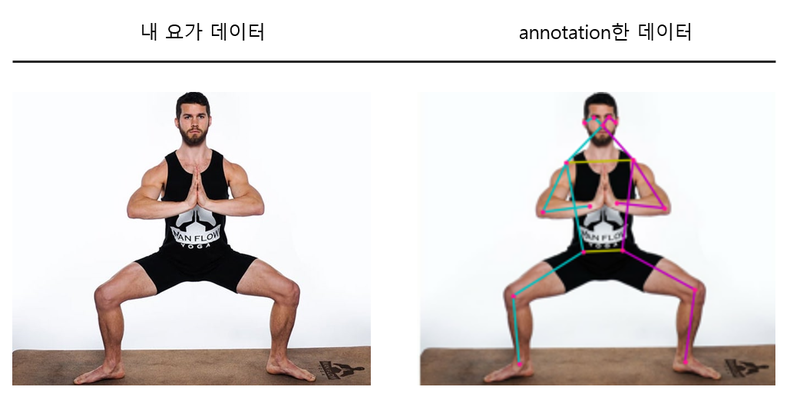

### 직접 annotation 해야 하는 걸까

우리에겐 현재 이미지만 달랑 있습니다. 즉 제가 keypoints들을 직접 찍어줘야 한다는 것이죠. 과거에 제가 직접 annotation을 해봤을 때를 상기하면 목과 어깨가 너무도 뻐근하고, 정신도 매우 피곤합니다. 데이터 회사에 맡기기엔 비싸고 직접 하기엔 너무 피곤하죠. 😫

Annotation을 필요로 하지 않는 모델들도 나오고 있지만 여전히 classification 태스크를 위해서 data annotation된 데이터가 필요한 경우가 많습니다. 그런데 저는 데이터에 직접 하나하나 annotation하기가 너무 싫었습니다! 😣

또한 저는 완벽하거나 정밀한 label이 아닌 coarse label을 만들어 일단 모델의 정확도가 향상되는지 보고 싶었습니다. 대충 coarse label을 만들어보기 위해 이미 존재하는 keypoints detection 모델을 사용해 그 inference 값을 사용해보면 좋겠다는 생각이 문득 들었죠!

그래서 이미 잘 학습된 keypoints detection model을 찾아보았고, 얼마 후 MoveNet: Ultra fast and accurate pose detection model를 알게 되었습니다. 한국어로 번역한다면 짱 빠르고 정확한이죠. 그 부분이 저를 사로잡았습니다. 저는 어느 정도 만들어진 label(여기서는 keypoints)로 대충 제 모델을 돌려보고 싶었거든요.

### MoveNet

기쁘게도 TensorFlow는 제가 원하는 MoveNet을 colab에서도 돌릴 수 있도록 해놓았습니다. 오예 🔥🔥

하지만 우리가 쓰려는 모델이 적어도 어떤 모델인지는 알고 가야겠죠? 위 링크에 있는 짤막한 MoveNet의 설명을 번역하고 약간의 설명을 덧붙이며 이 모델이 어떤 건지 알아가는 시간을 짧게 가져보려고 합니다.

MoveNet은 17개로 이루어진 바디 키포인트를 디텍팅하는 짱 빠르고 정확한 모델입니다. 이 모델은 TF Hub에서 Lightning과 Thunder로 알려진 두 가지 버전(variants)으로 제공됩니다. Lightning은 레이턴시(latency)가 중요한 어플리케이션을 위해 만들어졌고, Thunder는 높은 정확도를 요하는 어플리케이션을 위해 만들어졌습니다. 두 모델은 둘 다 실시간으로 (30+FPS) 데스크톱, 랩톱, 폰에서 사용할 수 있고, 피트니스, 헬스, 웰니스 어플리케이션으로 증명되었습니다. (부가 설명 : latency가 중요하다는 것은 속도가 중요하다는 것입니다.)

MoveNet의 output으로 나올 17개의 keypoints는 COCO 스탠다드를 따랐으며 그 keypoints의 종류는 다음과 같습니다!

“nose”, “left_eye”, “right_eye”, “left_ear”, “right_ear”, “left_shoulder”, “right_shoulder”, “left_elbow”, “right_elbow”, “left_wrist”, “right_wrist”, “left_hip”, “right_hip”, “left_knee”, “right_knee”, “left_ankle”, “right_ankle”

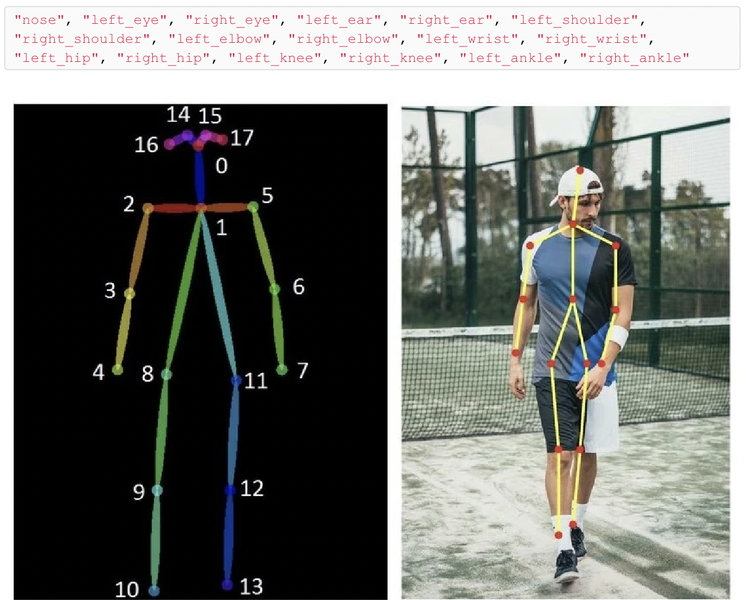

위 그림을 보시면 총 17개의 keypoints가 동그라미로 찍혀있고 그 keypoints들을 직선으로 연결하고 있는 모습이 보입니다.

그렇다면 제가 사용하려는 데이터는 정확히 무엇일까요?

맞습니다. 바로 이미지에 있는 사람의 17개 keypoints의 좌표 (x, y) 값입니다. 총 17개이고 각각 x, y 좌표를 가지고 있기 때문에 (17, 2) 사이즈인 데이터를 사용할 것입니다.

자 이제 어떤 방식으로 제가 사용하고 있는 Yogapose 이미지에 annotation을 해보았는지 보여드릴 차례입니다. MoveNet에서 제공하는 colab에 있는 TensorFlow 코드와 제 머리에서 나온 코드의 콜라보를 보여드리겠습니다.

### MoveNet 모델 가져오기 & 환경설정하기

저는 movenet_lightning을 사용했습니다. 아까 말씀드렸던 것과 같이 lightning은 주로 빠른 속도를 원할 때 사용합니다. MoveNet으로부터 얻은 keypoints를 통해 학습할 제 CNN 모델의 정확도가 어느 정도 이상만 향상되면 괜찮을 것이라고 예상했고, 더욱 정확한 keypoints까지 필요할까라고 생각했기 때문에 이 모델을 골랐습니다. 하지만 lightning보다는 조금 느리지만 keypoints의 정확도가 조금 더 높은 것을 원하시는 분은 Thunder를 사용하시는 게 좋을 것입니다.

In [48]:
# !pip install -q imageio
# !pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [49]:
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import cv2

# matplotlib 라이브러리 import
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# 이미지 display를 도와주는 imageio import
import imageio
from IPython.display import HTML, display

model_name = "movenet_lightning"

if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

In [50]:
def movenet(module, input_image):
    """Runs detection on an input image.
    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

### Annotation할 데이터 가져오기

Annotation할, 즉 body keypoint가 필요한 이미지 데이터들을 가져와 봅시다.

In [51]:
from pathlib import Path

# 데이터 셋 위치
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
classes

[PosixPath('/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess'),
 PosixPath('/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank'),
 PosixPath('/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog'),
 PosixPath('/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree'),
 PosixPath('/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2')]

우리가 가진 총 5개의 클래스에 속한 이미지 파일 경로를 모두 불러올 것입니다.

In [53]:
train_files = []
for cls in classes:
    train_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
train_files[:3], len(train_files)

(['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000164.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000145.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000097.jpg'],
 861)

짜잔!

validation과 test 데이터도 똑같이 해주겠습니다.






In [54]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/VAL'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
val_files = []
for cls in classes:
    val_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
val_files[:3], len(val_files)

(['/aiffel/aiffel/model-fit/data/DATASET/VAL/goddess/00000164.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/VAL/goddess/00000250.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/VAL/goddess/00000106.jpg'],
 390)

In [55]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TEST'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
test_files = []
for cls in classes:
    test_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
test_files[:3], len(test_files)

(['/aiffel/aiffel/model-fit/data/DATASET/TEST/goddess/00000073.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/TEST/goddess/00000016.jpg',
  '/aiffel/aiffel/model-fit/data/DATASET/TEST/goddess/00000085.jpg'],
 470)

### nference 해서 json으로 저장하기

아래는 TensorFlow 에서 제공하는 코드를 기반으로 17개의 body key points만을 리턴하도록 수정한 코드입니다.

In [57]:
def get_keypoints(image, 
                  keypoints_with_scores,
                  output_image_height=None, 
                  keypoint_threshold=0.0):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height

    keypoints_all = []
    num_instances,_,_,_ = keypoints_with_scores.shape
    for id in range(num_instances):
        kpts_x = keypoints_with_scores[0,id,:,1]
        kpts_y = keypoints_with_scores[0,id,:,0]
        kpts_scores = keypoints_with_scores[0,id,:,2]
        kpts_abs_xy = np.stack(
            [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
        kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
        keypoints_all.append(kpts_above_thrs_abs)

    return np.concatenate(keypoints_all,axis=0)


자, 이제! 위에서 얻은 이미지 파일들을 각각 inference해서 {'file path' : (17, 2) 배열} 형태로 dictionary에 저장해봅시다!

In [58]:
import json

def make_keypoints_json(files, module, input_size):
    keypoints = {}
    removed = []
    for image_path in files:
        # 이미지 에러에 대한 처리
        # 이미지가 tf.io.read_file로 읽을 수 없는 타입인 경우에 대비
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image)
        except:
            print('image error : ', image_path)
            removed.append(image_path)
            continue

        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

        # 모델 인퍼런스 에러에 대한 처리
        try:
            keypoints_with_scores = movenet(module, input_image)
            # print(keypoints_with_scores)
        except Exception as e:
#             print(input_image.shape)
            print('modl error : ', image_path)
            removed.append(image_path)
            continue

        keypoint_image = tf.expand_dims(image, axis=0)
        keypoint_image = tf.cast(tf.image.resize_with_pad(
            keypoint_image, 224, 224), dtype=tf.int32)
        output_overlay = get_keypoints(np.squeeze(keypoint_image.numpy(), axis=0), 
                                      keypoints_with_scores)
        # print(os.path.join('/'.join(image_path.split('/'))))
        keypoints.setdefault(os.path.join('/'.join(image_path.split('/'))), output_overlay.tolist())
        
    return keypoints, removed

In [59]:
train_keypoints, train_removed_files = make_keypoints_json(train_files, module, input_size)

modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000272.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000282.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000127.png


Corrupt JPEG data: premature end of data segment


modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000193.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000204.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000179.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000263.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000330.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000307.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000294.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank/00000290.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000287.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000212.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000352.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000379.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog/

In [60]:
val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)

modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/goddess/00000261.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/goddess/00000193.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000170.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000136.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000236.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000146.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000263.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000187.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000294.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/plank/00000388.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/downdog/00000287.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/downdog/00000351.png
modl error :  /aiffel/aiffel/model-fit/data/DATASET/VAL/downdog/00000352.png
modl error :  /

슬프게도 어떤 이미지들은 모델이 제대로 inference 하지 못했습니다.. 이유가 궁금하신 분들이 있을 것 같은데요. 그런 분들은 Exception 내의 에러를 찍어보시면 알게 되실겁니다. 일단 이 이미지들은 사용하지 않는 것으로 하겠습니다.

하지만 나머지 이미지들은 keypoints dictionary 를 확인해보니 잘 저장이 된 것 같네요! 이제 val, test 데이터 모두 keypoints를 똑같이 뽑아주겠습니다.

후에 얻은 keypoints 들을 json 파일로 저장하여 모델을 학습할 때 load해서 사용할 것입니다.

In [1]:
val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)

SyntaxError: invalid syntax (2242109227.py, line 1)

In [ ]:
test_keypoints, test_removed_files = make_keypoints_json(test_files, module, input_size)

슬프게도 어떤 이미지들은 모델이 제대로 inference 하지 못했습니다.. 이유가 궁금하신 분들이 있을 것 같은데요. 그런 분들은 Exception 내의 에러를 찍어보시면 알게 되실겁니다. 일단 이 이미지들은 사용하지 않는 것으로 하겠습니다.

하지만 나머지 이미지들은 keypoints dictionary 를 확인해보니 잘 저장이 된 것 같네요! 이제 val, test 데이터 모두 keypoints를 똑같이 뽑아주겠습니다.

후에 얻은 keypoints 들을 json 파일로 저장하여 모델을 학습할 때 load해서 사용할 것입니다.

In [ ]:
# # train, val keypoints 합쳐서 한 번에 저장하기
train_keypoints.update(val_keypoints)
train_keypoints.keys()
with open("aiffel/model-fit/keypoints_train_val.json", "w") as json_file:
    json.dump(train_keypoints, json_file)

# with open("/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
#     keypoint_dict = json.load(json_file)
# keypoint_dict

In [ ]:
# test keypoints 저장하기
with open("aiffel/model-fit/keypoints_test.json", "w") as json_file:
    json.dump(test_keypoints, json_file)

In [ ]:
# keypoints_train_val.json, keypoints_test.json이 제대로 생겼는지 확인
!ls aiffel/model-fit

keypoints를 뽑지 못한 이미지들은 removed라는 이름의 list에 미리 경로를 넣어두었습니다. 아래의 코드를 이용해 과감히 삭제해버리겠습니다.

In [ ]:
def remove_files(removed):
    for file_path in removed:
        try:
            os.remove(file_path)
        except:
            print(file_path)

In [ ]:
remove_files(train_removed_files)
remove_files(val_removed_files)
remove_files(test_removed_files)

### 이미지 데이터와 keypoints 데이터를 로드하는 데이터로더 만들기

데이터를 만들었으니 이제 기존에 가지고 있던 이미지만 로드하는 데이터로더가 아닌 이미지와 keypoints 모두를 로드하는 데이터로더가 필요합니다. 우리의 새 데이터로더는 image, label 형태가 아닌 {"input_1": img, "input_2": keypoint}, label로 데이터를 로드할 것입니다!

In [ ]:
keypoint = {}

def process_keypoint(file_path):
    global keypoint_dict
    file_path = file_path.numpy().decode('utf-8')
    file_path = os.path.join('./', file_path)
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)
    return keypoint

def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape) 

    [keypoint,] = tf.py_function(process_keypoint, [file_path], [tf.float32])

    return {"input_1": img, "input_2": keypoint}, label

def augment(inputs, label):
    image, keypoint = inputs['input_1'], inputs['input_2']
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.adjust_brightness(image, 0.4)
    image = tf.image.random_brightness(image, max_delta=0.4)
    return {'input_1' : image, 'input_2' : keypoint}, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, training=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    if training:
        ds = ds.map(lambda x, y: augment(x, y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()


def load_data(data_path, img_shape=(224, 224), batch_size=32, training=True):
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    global keypoint_dict
    if training:
        with open("/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
            keypoint_dict = json.load(json_file)
    else:
        with open("/aiffel/aiffel/model-fit/keypoints_test.json", "r") as json_file:
            keypoint_dict = json.load(json_file)

    return ds, DATASET_SIZE

코드에 대한 약간의 설명이 필요할 것 같습니다.

이전처럼 single input을 사용하는 모델이라면 prcoess_path에서 img, label을 return을 해주었을 것입니다. 하지만 지금은 들어오는 img뿐만 아니라 keypoints도 가져와야 합니다. process_keypoint 함수를 이용하여 keypoint를 가져온 후 img, keypoint, label을 리턴해줍니다.

```
def process_keypoint(file_path):
    global keypoint_dict
    file_path = file_path.numpy().decode('utf-8')
    file_path = os.path.join('./', file_path)
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)
    return keypoint

	def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape) 

    [keypoint,] = tf.py_function(process_keypoint, [file_path], [tf.float32])

    return {"input_1": img, "input_2": keypoint}, label
```

prepare_for_training에서 augmentation해줄 때도 image, keypoint = inputs['input_1'], inputs['input_2']를 통해 image를 가져와서 image만 augmentation해주어야 합니다. 이 때 주의할 점은 keypoints를 사용할 것이기 때문에 좌우 flip과 같은 augmentation은 하지 않도록 해야 한다는 것입니다.

```
def augment(inputs, label):
    image, keypoint = inputs['input_1'], inputs['input_2']
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.adjust_brightness(image, 0.4)
    image = tf.image.random_brightness(image, max_delta=0.4)
    return {'input_1' : image, 'input_2' : keypoint}, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, training=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    if training:
        ds = ds.map(lambda x, y: augment(x, y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds
```

load_data의 역할은 라벨 로드, 이미지 로드, 데이터 배치 만들기 등의 역할을 하는 함수를 호출하여 최종으로 받을 데이터를 만드는 역할을 합니다.

```
def load_data(data_path, img_shape=(224, 224), batch_size=32, training=True):
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    global keypoint_dict
    if training:
        with open("/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
            keypoint_dict = json.load(json_file)
    else:
        with open("/aiffel/aiffel/model-fit/keypoints_test.json", "r") as json_file:
            keypoint_dict = json.load(json_file)

    return ds, DATASET_SIZE
```

자 이제 데이터를 잘 가져오는지 확인해볼까요?

In [ ]:
# 내 데이터 위치
train_data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'

train_ds, train_size = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=1)

for inputs in train_ds.take(1):
    print(inputs)

음~ 잘되는군요. 자 이제 모델을 입력이 두 개인 multiple input을 가진 모델로 바꿔보겠습니다!






In [ ]:
from tensorflow.keras.applications import VGG16

class YogaPose(tf.keras.Model):
    def __init__(self, num_classes=30, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        self.keypoint = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(17, 2)),
                                              tf.keras.layers.Dense(34),])
        
        if freeze:
            self.base_model.trainable = False

        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.6, name="top_dropout")])
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")

    def call(self, inputs, training=True):
        image, keypoint = inputs['input_1'], inputs['input_2']
        x1 = self.base_model(image)
        x1 = self.top(x1)
        x2 = self.keypoint(keypoint)
        x = self.concat([x1, x2])
        x = self.classifier(x)
        return x

call function을 통해 input이 들어오게 되겠죠? 우리의 dataloader가 리턴해주는 데이터의 형태는 {"input_1": img, "input_2": keypoint}, label이기 때문에 image, keypoint = inputs['input_1'], inputs['input_2'] 코드처럼 image, keypoint 각각을 저장해야 합니다.

```
def call(self, inputs, training=True):
    image, keypoint = inputs['input_1'], inputs['input_2']
    x1 = self.base_model(image)
    x1 = self.top(x1)
    x2 = self.keypoint(keypoint)
    x = self.concat([x1, x2])
    x = self.classifier(x)
    return x
```

그리고 위의 코드처럼 각각의 입력을 받아줄 레이어도 지정해줍니다. image를 받을 레이어는 self.base_model, keypoint를 받을 레이어는 self.keypoint입니다.

자 이제 모델이 어떤 input을 넣었을 때 output이 잘 나오는지 볼까요?

In [ ]:
# 가짜 input
inputs = {'input_1':tf.ones([1, 224, 224, 3]), 'input_2':tf.ones([1, 17, 2])}
model = YogaPose(num_classes=2, freeze=True)
model(inputs)

값이 잘 나오네요!
이제 모델을 학습해서 결과를 보는 일만 남았습니다!






In [ ]:
from tensorflow.keras.utils import Progbar
import math

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [ ]:
train_data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN' 
val_data_path = '/aiffel/aiffel/model-fit/data/DATASET/VAL' 
batch_size = 16

train_ds, TRAIN_SIZE = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_data_path, img_shape=(224, 224), batch_size=batch_size)

In [ ]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

# epoch을 조정해 보세요. 
trainer = Trainer(model=model,
                  epochs=100,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)`

학습이 되기 시작했습니다. 우리의 여정이 거의 끝나갑니다.
잠깐 쉬어가기 타임으로 모델의 수많은 하이퍼파라미터들을 잘 정리해서 넘기는 방법인 argparse에 대해 이야기하고 갈까 합니다.

#### argparse 사용하기

argparse는 주피터 노트북에서는 사용하지 않아도 되는 기능이지만 파이썬 파일에 이걸 넣으면 왠지 멋있어 보이니까 그냥 설명하겠습니다.

사실 멋있는 것도 중요하지만, argparse를 사용하면 매번 코드에서 값을 바꿔주지 않고도 python main.py 명령만으로 실험에 필요한 epoch, batch, data path 등을 설정해줄 수 있습니다!

우리가 처음 목표로 했던 트리를 기억해보세요. 주피터 셀로 공부하고 있지만 나중엔 main.py만 실행하여 전체 프로세스를 학습하게 하는게 좋겠죠!

```
/Users/eden/ByeModelFitFunc
├── DATASET
│   ├── TRAIN
│   ├── VAL
│   └── TEST
│
├── dataset.py		       # dataset loader
├── label.txt			    # dataset 클래스 이름이 있는 txt 파일
├── loss.py			      # loss function
├── main.py			      # model and data set, train
├── trainer.py			   # trainer
└── model.py			     # model
```
파이썬 파일 실행 시 num_classes, epoch, batch_size, data_path 등을 받을 수 있도록 바꿔보겠습니다.

아래처럼 다 따로 따로 주었던 값들을 묶어서 쉽게 변경하고 사용할 수 있도록 할 것입니다.

```
if __name__ == '__main__':
    num_classes = 5
    epoch = 50
    batch_size = 16

    train_data_path = './DATASET/TRAIN'
    val_data_path = './DATASET/VAL0000'
    
    checkpoint_path = './checkpoints'

    train_ds, TRAIN_SIZE = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=batch_size)
    val_ds, VAL_SIZE = load_data(data_path=val_data_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)
```

이렇게 말이죠!

```
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--epoch",          type=int,       default=100)
parser.add_argument("--batch_size",     type=int,       default=64)
parser.add_argument("--num_classes",    type=int,       default=107)
parser.add_argument("--img_size",       type=int,       default=224)
parser.add_argument("--train_path",     type=str,		default='./DATASET/TRAIN')
parser.add_argument("--val_path",       type=str,		default='./DATASET/VAL')
parser.add_argument("--checkpoint_path",type=str,		default='./checkpoints')

args = parser.parse_args()
```

후에 받은 인자들은 args.batch_size와 같이 사용하면 됩니다. 짜잔 python main.py — batch_size 32 — checkpoint_path ‘.’ 로 실행보면 됩니다. 위에서 batch_size가 default로 16으로 지정되어있지만 각자의 데이터에 맞게 여러가지를 실험해보는 것이 좋습니다.

지금 당장은 사용하지 않지만 나중에 파이썬 파일로 코드를 짤 때 유용한 기능이니, 잊지 말고 사용해 보세요! 😊

### 모델 테스트해보기

제가 잊고 있던 것이 하나 있었습니다. 바로 모델 테스트입니다. 이게 진짜 진짜 마지막입니다. 학습한 모델이 잘 테스트 되는지도 역시 중요하죠. train acc는 분명 높았는데 test acc는 낮을 수도 있을 확률도 꽤 있기 때문입니다.

짧은 코드와 함께 테스트해보겠습니다.방법은 간단합니다. tf.train.Checkpoint로 이미 저장된 ckpt를 가져오면 됩니다. ckpt에는 우리가 만든 모델이 그대로 저장되어 있기 때문입니다. 그 후 다시 데이터를 로드한 후 모델을 inference해서 진짜 label과 inference 결과를 비교하여, 그 값이 몇 개나 맞았는지 체크해보면 되죠. 아래는 그 과정입니다.

In [ ]:
num_classes = 1 
epoch = 1 
batch_size = 16
img_size = 224
test_data_path =  '/aiffel/aiffel/model-fit/data/DATASET/TEST'

checkpoint_path = './checkpoints/'

model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

test, TEST_SIZE = load_data(data_path=test_data_path, img_shape=(img_size, img_size), batch_size=batch_size, training=False)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

for step_train, (x_batch_train, y_batch_train) in enumerate(test.take(10)):
    # print(model(x_batch_train))
    prediction = model(x_batch_train)
    # print(tf.argmax(y_batch_train, axis=1))
    # print(tf.argmax(prediction, axis=1))
    # print(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1)))
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))
    # print("Prediction: {}".format(tf.argmax(prediction, axis=1)))

결과가 그리 좋지는 않습니다. epoch 수가 적어서일까요? 아니면 데이터의 크기가 그리 크지 않아서 결과가 좋지 않을 수도 있습니다.

하지만 model.fit()에서 벗어나기의 목표는 테스트 결과를 높이는 것이 아니라 커스텀 데이터를 커스텀 트레이너로 학습하는 것이었다는 것을 잊지 마세요. 직접 트레이너를 만들어 모델을 학습하는 방법을 여러분께 알려드렸으니 저의 역할은 여기까지입니다. 테스트 결과를 높이는 것은 여러분의 몫으로 남겨두겠습니다. 😸